# Group Assignment: WQD7003 DATA ANALYTICS
# Predicting the survival status of COVID-19 patient

### Group Members:

1.   LEE RE XUAN   (24071969)                         
2.   YIM WEN JUN   (24201054)
3.   RICHIE TEOH   (24088171)
4.   ELMER LEE JIA ZHAO  (24082366)
5.   ANGELINE TAN JIE LIN  (24084444)
6.   MICOLE CHUNG SYN TUNG (24073625)

---

# Business Understanding
This project aims to develop a classification model to predict the survival status of COVID-19 patients. By identifying high-risk individuals early, healthcare providers can prioritize care and allocate resources more effectively, ultimately improving patient outcomes and reducing fatality rates.

## Problem Statement

- Hospital staff lack of data-driven way to know which COVID-19 patients contain high risk of deteriorate and die.

- Without early risk stratification and detection, urgent resources or healthcare services may be allocated too late to the patients who would survive without them.


## Stakesholder list

### 1. Clinicians (Physicians and Nurses)

-	This model can help to provide early action if a patient is at high risk of death so they can intensify monitoring or escalate to ICU sooner.

-	Their concern of using this model will be predicting false positive or false negative. As this deals with patient health conditions, it may cause delays for early interventions.  

### 2.	Hospital Administrators and Resource Planners

-	Short-term forecasts of expected COVID-related deaths to plan bed capacity, staffing schedules, and supply orders (e.g. ventilators, oxygen tanks).

-	Overestimating risk leads to under-utilized resources; underestimating risk can cause sudden shortages.


## Success Criteria:

Targeting to achieve ≥ 70% for all metrics.

<table border="1">
  <tr>
    <th>Value Range</th>
    <th>Rating</th>
    <th>Interpretation</th>
  </tr>
  <tr>
    <td>0.1 - 0.5</td>
    <td>
      Poor
    <td>
      Unacceptably low
    </td>
  </tr>
  <tr>
    <td>0.5 - 0.7</td>
    <td>
       Fair
    <td>
      Marginal
    </td>
  </tr>
  <tr>
    <td>0.7 - 1.0</td>
    <td>
      Good
    <td>
      Acceptable
    </td>
  </tr>
</table>




| Metric                          | Rationale                                                                                                  |
| ------------------------------- | ---------------------------------------------------------------------------------------------------------- |
| **Accuracy ≥ 0.75**             | Ensures at least three out of four overall predictions are correct, reducing wasted review time.           |
| **Precision ≥ 0.70**            | No more than 30% of flagged patients will survive, limiting unnecessary ICU alerts.                        |
| **Recall (Sensitivity) ≥ 0.72** | Captures at least 72% of true deaths, minimizing missed high-risk cases.                                   |
| **Specificity ≥ 0.80**          | Keeps false-alarm rates to 20% or less, maintaining a realistic balance between sensitivity and precision. |
| **F1 Score ≥ 0.70**             | Balances precision and recall. A value below 0.70 indicates one of those two is too low.                   |
| **ROC-AUC ≥ 0.80**              | Indicates strong overall ability to classify “will die” vs. “will survive.”                                |
| **AUPRC ≥ 0.70**                | Ensures good performance on the positive class (death) in the presence of class imbalance.                 |


## Model-Related Constrains/ Risks

### 1.	Overfitting to Historical Waves:

-	Early pandemic waves pattern may not be compatible with new variants or improved treatments.

### 2.	Bias and Fairness

-	Some demographic groups may be underrepresented; the model might systematically under or over predict their risk.


## Key Assumptions

### 1. Uniform Lab Reference Ranges:

- Laboratory values are measured on the same equipment with consistent reference ranges across sites, so numeric values are directly comparable.

### 2. No Major Treatment Protocol Shifts:

- Throughout the project window, there will be no introduction of new, drastically different therapies that would significantly change mortality risk patterns.

### 3. Pregnancy Data Characteristics Did Not Affect COVID-19 Mortality Risk:

- Throughout the project, the assumption is make that pregnancy data characteristics would not affect the risk of death from COVID-19.


---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import os

## Introduction of the Dataset
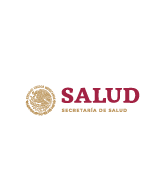

provided by Mexico Government, from the Epidemiological Surveillance System for Viral Respiratory diseases, published in 2020-04-14, contains anonymized patient-related information including pre-conditions.

In [2]:
df = pd.read_csv(f'Covid Data.csv')
df.columns = df.columns.str.lower()
df = df.rename(columns = {'usmer':'usmr',
                          'pregnant':'pregnancy',
                          'hipertension':'hypertension',
                          'clasiffication_final': 'classification'})
df.head()

,usmr,medical_unit,sex,patient_type,date_died,intubed,pneumonia,age,pregnancy,diabetes,...,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,classification,icu
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


In [3]:
descriptions = {
    "sex": "1 for female and 2 for male.",
    "age": "Age of the patient.",
    "classification": "COVID-19 test findings. Values 1–3 = confirmed cases, 4+ = not a carrier or inconclusive.",
    "patient_type": "Type of care: 1 = returned home, 2 = hospitalized.",
    "pneumonia": "Whether the patient had pneumonia (air sac inflammation).",
    "pregnancy": "Whether the patient is pregnant (1 = yes, 2 = no).",
    "diabetes": "Whether the patient has diabetes (1 = yes, 2 = no).",
    "copd": "Whether the patient has Chronic Obstructive Pulmonary Disease (1 = yes, 2 = no).",
    "asthma": "Whether the patient has asthma (1 = yes, 2 = no).",
    "inmsupr": "Whether the patient is immunosuppressed (1 = yes, 2 = no).",
    "hypertension": "Whether the patient has hypertension (1 = yes, 2 = no).",
    "cardiovascular": "Whether the patient has cardiovascular disease (1 = yes, 2 = no).",
    "renal_chronic": "Whether the patient has chronic kidney disease (1 = yes, 2 = no).",
    "other_disease": "Whether the patient has other diseases (1 = yes, 2 = no).",
    "obesity": "Whether the patient is obese (1 = yes, 2 = no).",
    "tobacco": "Whether the patient is a tobacco user (1 = yes, 2 = no).",
    "usmr": "Medical unit level: 1st, 2nd or 3rd level treatment center.",
    "medical_unit": "Institution of the National Health System that provided care.",
    "intubed": "Whether the patient was connected to a ventilator (1 = yes, 2 = no).",
    "icu": "Whether the patient was admitted to the Intensive Care Unit (1 = yes, 2 = no).",
    "date_died": "If the patient died, the date of death is shown; otherwise, 9999-99-99."
}

metadata = pd.DataFrame({
    "Column Name": df.columns,
    "Data Type": df.dtypes.values,
    "Non-Null Count": df.notnull().sum().values,
    "Null Count": df.isnull().sum().values,
    "Unique Values": df.nunique().values,
    "Sample Values": [df[col].dropna().unique()[:3] for col in df.columns],
    "Description": [descriptions[col] for col in df.columns]
})

pd.set_option('display.max_colwidth', None)
metadata

,Column Name,Data Type,Non-Null Count,Null Count,Unique Values,Sample Values,Description
0,usmr,int64,1048575,0,2,"[2, 1]","Medical unit level: 1st, 2nd or 3rd level treatment center."
1,medical_unit,int64,1048575,0,13,"[1, 2, 3]",Institution of the National Health System that provided care.
2,sex,int64,1048575,0,2,"[1, 2]",1 for female and 2 for male.
3,patient_type,int64,1048575,0,2,"[1, 2]","Type of care: 1 = returned home, 2 = hospitalized."
4,date_died,object,1048575,0,401,"[03/05/2020, 03/06/2020, 09/06/2020]","If the patient died, the date of death is shown; otherwise, 9999-99-99."
5,intubed,int64,1048575,0,4,"[97, 1, 2]","Whether the patient was connected to a ventilator (1 = yes, 2 = no)."
6,pneumonia,int64,1048575,0,3,"[1, 2, 99]",Whether the patient had pneumonia (air sac inflammation).
7,age,int64,1048575,0,121,"[65, 72, 55]",Age of the patient.
8,pregnancy,int64,1048575,0,4,"[2, 97, 98]","Whether the patient is pregnant (1 = yes, 2 = no)."
9,diabetes,int64,1048575,0,3,"[2, 1, 98]","Whether the patient has diabetes (1 = yes, 2 = no)."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 21 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   usmr            1048575 non-null  int64 
 1   medical_unit    1048575 non-null  int64 
 2   sex             1048575 non-null  int64 
 3   patient_type    1048575 non-null  int64 
 4   date_died       1048575 non-null  object
 5   intubed         1048575 non-null  int64 
 6   pneumonia       1048575 non-null  int64 
 7   age             1048575 non-null  int64 
 8   pregnancy       1048575 non-null  int64 
 9   diabetes        1048575 non-null  int64 
 10  copd            1048575 non-null  int64 
 11  asthma          1048575 non-null  int64 
 12  inmsupr         1048575 non-null  int64 
 13  hypertension    1048575 non-null  int64 
 14  other_disease   1048575 non-null  int64 
 15  cardiovascular  1048575 non-null  int64 
 16  obesity         1048575 non-null  int64 
 17  renal_ch

In [5]:
#Identifying dirty data
print(df.isna().sum())

print(df.isnull().values.any())

usmr              0
medical_unit      0
sex               0
patient_type      0
date_died         0
intubed           0
pneumonia         0
age               0
pregnancy         0
diabetes          0
copd              0
asthma            0
inmsupr           0
hypertension      0
other_disease     0
cardiovascular    0
obesity           0
renal_chronic     0
tobacco           0
classification    0
icu               0
dtype: int64
False


In [6]:
df.nunique()
# In the metadata provided, features such as hypertension should only have 2 UNIQUE values, but 3 is shown in df.unique(), requires investigation

usmr                2
medical_unit       13
sex                 2
patient_type        2
date_died         401
intubed             4
pneumonia           3
age               121
pregnancy           4
diabetes            3
copd                3
asthma              3
inmsupr             3
hypertension        3
other_disease       3
cardiovascular      3
obesity             3
renal_chronic       3
tobacco             3
classification      7
icu                 4
dtype: int64

---

# Data Pre-processing
In this phase, the dataset is cleaned and prepared for modeling. This includes handling missing values, encoding categorical variables, normalizing or scaling numerical features, and addressing class imbalance to ensure the data is ready for training an accurate and reliable classification model.

## Data Cleaning
The process to ensure data has been cleaned before implement data exploratation.

### Selecting & Filtering irrelevant data
Filtering irrelevant data that will affect the result of the analysis.

<table border="1">
  <tr>
    <th> Data Attribute </th>
    <th> Justification </th>
  </tr>
  <tr>
    <td> Classification </td>
    <td> covid test findings. Values 1-3 mean that the patient was diagnosed with covid </td>
  </tr>
</table>

In [7]:
df_filtering = df.copy() #Copy the dataset from original dataset
df_filtering = df_filtering[df_filtering['classification'] < 4] #classification: covid test findings. Values 1-3 mean that the patient was diagnosed with covid
df_filtering

,usmr,medical_unit,sex,patient_type,date_died,intubed,pneumonia,age,pregnancy,diabetes,...,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,classification,icu
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97
5,2,1,1,2,9999-99-99,2,1,40,2,2,...,2,2,2,2,2,2,2,2,3,2
6,2,1,1,1,9999-99-99,97,2,64,2,2,...,2,2,2,2,2,2,2,2,3,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047933,1,13,1,2,9999-99-99,2,2,77,2,1,...,2,1,1,2,2,2,2,2,3,2
1047934,1,13,1,1,9999-99-99,97,2,55,2,1,...,2,2,2,2,2,2,2,2,3,97
1047935,1,13,2,1,9999-99-99,97,2,70,97,2,...,2,2,1,2,2,2,2,2,3,97
1047936,2,13,2,1,9999-99-99,97,2,32,97,2,...,2,2,2,2,2,2,2,2,3,97


In [8]:
#Mapping the value 2 into 0, to indicate No.
mapping_col = {
    'pneumonia', 'pregnancy', 'diabetes', 'copd', 'asthma',
       'inmsupr', 'hypertension', 'other_disease', 'cardiovascular', 'obesity', "intubed",
       'renal_chronic', 'tobacco', 'icu',
}

mapping_col = list(mapping_col)
df_filtering[mapping_col] = df_filtering[mapping_col].replace(2, 0)
df_filtering

,usmr,medical_unit,sex,patient_type,date_died,intubed,pneumonia,age,pregnancy,diabetes,...,asthma,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,classification,icu
0,2,1,1,1,03/05/2020,97,1,65,0,0,...,0,0,1,0,0,0,0,0,3,97
2,2,1,2,2,09/06/2020,1,0,55,97,1,...,0,0,0,0,0,0,0,0,3,0
4,2,1,2,1,21/06/2020,97,0,68,97,1,...,0,0,1,0,0,0,0,0,3,97
5,2,1,1,2,9999-99-99,0,1,40,0,0,...,0,0,0,0,0,0,0,0,3,0
6,2,1,1,1,9999-99-99,97,0,64,0,0,...,0,0,0,0,0,0,0,0,3,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047933,1,13,1,2,9999-99-99,0,0,77,0,1,...,0,1,1,0,0,0,0,0,3,0
1047934,1,13,1,1,9999-99-99,97,0,55,0,1,...,0,0,0,0,0,0,0,0,3,97
1047935,1,13,2,1,9999-99-99,97,0,70,97,0,...,0,0,1,0,0,0,0,0,3,97
1047936,2,13,2,1,9999-99-99,97,0,32,97,0,...,0,0,0,0,0,0,0,0,3,97


### Removing irrelevant features
Remove unused data attributes from the dataset

<table border="1">
  <tr>
    <th>Data Attribute</th>
    <th>Justification</th>
  </tr>
  <tr>
    <td>Other_disease</td>
    <td>
      Unclear and lack of specificity for making decision or analysis.
    </td>
  </tr>
  <tr>
    <td>Intubed</td>
    <td>
       Occur for severe decline in health and is closely correlated with impending death, making it a strong source of data leakage.
    </td>
  </tr>
  <tr>
    <td>Classification</td>
    <td>
      Confirmation of COVID-19 infection. Irrelevant to identifying the disease, it may not be predictive of death once the patient is already confirmed to have COVID-19.
    </td>
  </tr>
  <tr>
    <td>ICU</td>
    <td>
      When the patient was admitted to the Intensive Care Unit, meaning is nearly to death. This will make data leakage.
    </td>
  </tr>
</table>

In [9]:
df_cleaning = df_filtering.copy() #Copy the dataset from df_filtering dataset
df_cleaning = df_cleaning.drop(columns=['classification','other_disease','intubed','icu'])
df_cleaning

,usmr,medical_unit,sex,patient_type,date_died,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,cardiovascular,obesity,renal_chronic,tobacco
0,2,1,1,1,03/05/2020,1,65,0,0,0,0,0,1,0,0,0,0
2,2,1,2,2,09/06/2020,0,55,97,1,0,0,0,0,0,0,0,0
4,2,1,2,1,21/06/2020,0,68,97,1,0,0,0,1,0,0,0,0
5,2,1,1,2,9999-99-99,1,40,0,0,0,0,0,0,0,0,0,0
6,2,1,1,1,9999-99-99,0,64,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047933,1,13,1,2,9999-99-99,0,77,0,1,0,0,1,1,0,0,0,0
1047934,1,13,1,1,9999-99-99,0,55,0,1,0,0,0,0,0,0,0,0
1047935,1,13,2,1,9999-99-99,0,70,97,0,0,0,0,1,0,0,0,0
1047936,2,13,2,1,9999-99-99,0,32,97,0,0,0,0,0,0,0,0,0


### Standardization of Date
Using data parsing to convert the dates into a consistent format.

In [10]:
df_data_standarization = df_cleaning.copy() #Copy the dataset from df_cleaning dataset
df_data_standarization_alive = df_data_standarization[df_data_standarization['date_died'] == "9999-99-99"] #Subtract 9999-99-99 from the df_data_standarization data-frame
df_data_standarization.drop(df_data_standarization_alive.index, inplace=True) #Removing 9999-99-99 from the df_data_standarization data-frame
df_data_standarization['date_died'] = pd.to_datetime(df_data_standarization['date_died'], format='%d/%m/%Y').dt.date #convert the date from 03/05/2020 into 2022-05-03, keep as date-time

df_data_standarization = pd.concat([df_data_standarization, df_data_standarization_alive]) #merging together
df_data_standarization

,usmr,medical_unit,sex,patient_type,date_died,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,cardiovascular,obesity,renal_chronic,tobacco
0,2,1,1,1,2020-05-03,1,65,0,0,0,0,0,1,0,0,0,0
2,2,1,2,2,2020-06-09,0,55,97,1,0,0,0,0,0,0,0,0
4,2,1,2,1,2020-06-21,0,68,97,1,0,0,0,1,0,0,0,0
336,1,3,2,2,2020-03-28,1,47,97,0,1,0,0,1,0,1,0,0
337,2,3,2,2,2020-03-29,1,43,97,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047933,1,13,1,2,9999-99-99,0,77,0,1,0,0,1,1,0,0,0,0
1047934,1,13,1,1,9999-99-99,0,55,0,1,0,0,0,0,0,0,0,0
1047935,1,13,2,1,9999-99-99,0,70,97,0,0,0,0,1,0,0,0,0
1047936,2,13,2,1,9999-99-99,0,32,97,0,0,0,0,0,0,0,0,0


Coverting date_died into the status of the death_status (0 - Death, 1 - Alive)

In [11]:
df_data_standarization['death_status'] = np.where(df_data_standarization.date_died != '9999-99-99', 1, 0)
df_data_standarization['death_status'].value_counts()

a,b = df_data_standarization['death_status'].value_counts()[1], df_data_standarization['death_status'].value_counts()[0]
print(f'Imbalance Ratio:{100}:{b/a*100}')

Imbalance Ratio:100:622.7284460505938


### Spliting Data
This section will split the data into male and female groups for implementing missing data handling and mode-based imputation.

In [12]:
from IPython.display import display

df_data_standarization = df_data_standarization.drop(columns=['date_died']) #Drop the date_died column
# Male
df_male = df_data_standarization[df_data_standarization['sex'] == 2]
display(df_male.head())
print("\nNumber of male: ", len(df_male), " | Number of death: ", len(df_male[df_male['death_status'] == 0]) , " | Number of Alive: ", len(df_male[df_male['death_status'] == 1]) ,"\n")

# Female
df_female = df_data_standarization[df_data_standarization['sex'] == 1]
display(df_female.head())
print("\nNumber of female: ", len(df_female), " | Number of death: ", len(df_female[df_female['death_status'] == 0]) , " | Number of Alive: ", len(df_female[df_female['death_status'] == 1]) ,"\n")

,usmr,medical_unit,sex,patient_type,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,cardiovascular,obesity,renal_chronic,tobacco,death_status
2,2,1,2,2,0,55,97,1,0,0,0,0,0,0,0,0,1
4,2,1,2,1,0,68,97,1,0,0,0,1,0,0,0,0,1
336,1,3,2,2,1,47,97,0,1,0,0,1,0,1,0,0,1
337,2,3,2,2,1,43,97,0,0,0,0,0,0,0,0,1,1
338,2,3,2,2,1,86,97,0,1,0,0,0,0,0,0,1,1



Number of male:  209489  | Number of death:  174212  | Number of Alive:  35277 



,usmr,medical_unit,sex,patient_type,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,cardiovascular,obesity,renal_chronic,tobacco,death_status
0,2,1,1,1,1,65,0,0,0,0,0,1,0,0,0,0,1
339,1,3,1,2,0,53,0,0,0,0,0,0,0,0,0,0,1
347,2,3,1,2,1,72,0,0,0,0,0,0,0,1,0,0,1
359,1,3,1,2,1,61,0,0,0,0,0,1,1,0,0,0,1
363,1,3,1,2,1,84,0,1,0,0,0,0,0,0,0,0,1



Number of female:  182490  | Number of death:  163531  | Number of Alive:  18959 



### Handling Missing/Inaccuracy Data

#### Identify the missing data
Identify the values of 97, 98 and 99 in the dataset.

In [13]:
#Identify how many missing value for each data attributes
check_columns = df_data_standarization.columns
check_columns = check_columns.drop(['death_status','sex','age','usmr','medical_unit','patient_type']) #Remove the columns doesn't contain 1 (YES) and 0 (NO)

print("Checking missing value of 97, 98, 99 from Male ")
for checkMissing in check_columns:
  print(checkMissing, ": " , len(df_male[df_male[checkMissing].isin([97, 98, 99])]))

print("\nChecking missing value of 97, 98, 99 from Female ")
for checkMissing in check_columns:
  print(checkMissing, ": " , len(df_female[df_female[checkMissing].isin([97, 98, 99])]))

Checking missing value of 97, 98, 99 from Male 
pneumonia :  1
pregnancy :  209489
diabetes :  891
copd :  820
asthma :  818
inmsupr :  886
hypertension :  873
cardiovascular :  862
obesity :  843
renal_chronic :  840
tobacco :  910

Checking missing value of 97, 98, 99 from Female 
pneumonia :  3
pregnancy :  1383
diabetes :  549
copd :  493
asthma :  491
inmsupr :  563
hypertension :  515
cardiovascular :  529
obesity :  510
renal_chronic :  510
tobacco :  524


#### Mode-based Imputation
The data consists of 1 and 0, which fall under nominal data. The team will use mode-based imputation to handle the missing data values 97, 98, and 99.

In [14]:
from IPython.display import display
for checkMissing in check_columns:
  df_male[checkMissing] = df_male[checkMissing].replace([97, 98, 99], np.nan).fillna(df_male[checkMissing].mode()[0]).astype(int)

for checkMissing in check_columns:
  df_female[checkMissing] = df_female[checkMissing].replace([97, 98, 99], np.nan).fillna(df_female[checkMissing].mode()[0]).astype(int)

print("Checking missing value of 97, 98, 99 from Male | After Implement Mode-based Imputation")
for checkMissing in check_columns:
  print(checkMissing, ": " , len(df_male[df_male[checkMissing].isin([97, 98, 99])]))

print("\nChecking missing value of 97, 98, 99 from Female | After Implement Mode-based Imputation")
for checkMissing in check_columns:
  print(checkMissing, ": " , len(df_female[df_female[checkMissing].isin([97, 98, 99])]))

print("\nMale Data-Frame")
display(df_male.head())

print("\nFemale Data-Frame")
display(df_female.head())

Checking missing value of 97, 98, 99 from Male | After Implement Mode-based Imputation
pneumonia :  0
pregnancy :  209489
diabetes :  0
copd :  0
asthma :  0
inmsupr :  0
hypertension :  0
cardiovascular :  0
obesity :  0
renal_chronic :  0
tobacco :  0

Checking missing value of 97, 98, 99 from Female | After Implement Mode-based Imputation
pneumonia :  0
pregnancy :  0
diabetes :  0
copd :  0
asthma :  0
inmsupr :  0
hypertension :  0
cardiovascular :  0
obesity :  0
renal_chronic :  0
tobacco :  0

Male Data-Frame


,usmr,medical_unit,sex,patient_type,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,cardiovascular,obesity,renal_chronic,tobacco,death_status
2,2,1,2,2,0,55,97,1,0,0,0,0,0,0,0,0,1
4,2,1,2,1,0,68,97,1,0,0,0,1,0,0,0,0,1
336,1,3,2,2,1,47,97,0,1,0,0,1,0,1,0,0,1
337,2,3,2,2,1,43,97,0,0,0,0,0,0,0,0,1,1
338,2,3,2,2,1,86,97,0,1,0,0,0,0,0,0,1,1



Female Data-Frame


,usmr,medical_unit,sex,patient_type,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,cardiovascular,obesity,renal_chronic,tobacco,death_status
0,2,1,1,1,1,65,0,0,0,0,0,1,0,0,0,0,1
339,1,3,1,2,0,53,0,0,0,0,0,0,0,0,0,0,1
347,2,3,1,2,1,72,0,0,0,0,0,0,0,1,0,0,1
359,1,3,1,2,1,61,0,0,0,0,0,1,1,0,0,0,1
363,1,3,1,2,1,84,0,1,0,0,0,0,0,0,0,0,1


#### Removing Inaccurate Data
Remove inaccurate data that leads to incorrect information. (Eg. male pregnancy). Removing male and female pregnancy data was based on an assumption. The fact that, in the current case 209,489 male pregnancy data are missing with status '97', and directly impute the data as 0 would lead to data quality issues because these missing data labelled as '97' cannot be defined as other meanings and account for a large proportion of the male dataset. In addition, directly excluding these data would lead to data bias because the team assumed that pregnancy would not affect the COVID-19 mortality result.

In [15]:
 from IPython.display import display

 #Remove if sex is 1 and pregnancy is 1
 print("Before Removing: " , len(df_male[((df_male['pregnancy']== 1) & (df_male['sex'] == 2))]), " Number of Male data: ", len(df_male))
 df_male_clean = df_male.copy()

 df_male_clean = df_male.drop(df_male[(df_male['pregnancy'] == 1) & (df_male['sex'] == 2)].index)
 print("After Removing: " , len(df_male_clean[((df_male_clean['pregnancy']== 1) & (df_male_clean['sex'] == 2))]), " Number of Male data: ", len(df_male_clean))
 display(df_male_clean.head())

 #Number of pregnancy is equal to number of female, meaning none imputation should take action. Removing the columns.
 print("\nRemoving Pregnancy Attribute")
 print("\nMale Data-Frame")
 df_male_clean = df_male_clean.drop(columns=['pregnancy'])
 display(df_male_clean.head())

 print("\nFemale Data-Frame")
 df_female_clean = df_female.drop(columns=['pregnancy'])
 display(df_female_clean.head())

Before Removing:  0  Number of Male data:  209489
After Removing:  0  Number of Male data:  209489


,usmr,medical_unit,sex,patient_type,pneumonia,age,pregnancy,diabetes,copd,asthma,inmsupr,hypertension,cardiovascular,obesity,renal_chronic,tobacco,death_status
2,2,1,2,2,0,55,97,1,0,0,0,0,0,0,0,0,1
4,2,1,2,1,0,68,97,1,0,0,0,1,0,0,0,0,1
336,1,3,2,2,1,47,97,0,1,0,0,1,0,1,0,0,1
337,2,3,2,2,1,43,97,0,0,0,0,0,0,0,0,1,1
338,2,3,2,2,1,86,97,0,1,0,0,0,0,0,0,1,1



Removing Pregnancy Attribute

Male Data-Frame


,usmr,medical_unit,sex,patient_type,pneumonia,age,diabetes,copd,asthma,inmsupr,hypertension,cardiovascular,obesity,renal_chronic,tobacco,death_status
2,2,1,2,2,0,55,1,0,0,0,0,0,0,0,0,1
4,2,1,2,1,0,68,1,0,0,0,1,0,0,0,0,1
336,1,3,2,2,1,47,0,1,0,0,1,0,1,0,0,1
337,2,3,2,2,1,43,0,0,0,0,0,0,0,0,1,1
338,2,3,2,2,1,86,0,1,0,0,0,0,0,0,1,1



Female Data-Frame


,usmr,medical_unit,sex,patient_type,pneumonia,age,diabetes,copd,asthma,inmsupr,hypertension,cardiovascular,obesity,renal_chronic,tobacco,death_status
0,2,1,1,1,1,65,0,0,0,0,1,0,0,0,0,1
339,1,3,1,2,0,53,0,0,0,0,0,0,0,0,0,1
347,2,3,1,2,1,72,0,0,0,0,0,0,1,0,0,1
359,1,3,1,2,1,61,0,0,0,0,1,1,0,0,0,1
363,1,3,1,2,1,84,1,0,0,0,0,0,0,0,0,1


## Handling Imbalance Dataset

Implement **Random Undersampling** to removes random instances from the majority class

In [16]:
print("Number of death of male: ", len(df_male_clean[df_male_clean['death_status'] == 1]))
print("Number of no death of male: ", len(df_male_clean[df_male_clean['death_status'] == 0]))

print("Number of death of female: ", len(df_female_clean[df_female_clean['death_status'] == 1]))
print("Number of no death of female: ", len(df_female_clean[df_female_clean['death_status'] == 0]))

Number of death of male:  35277
Number of no death of male:  174212
Number of death of female:  18959
Number of no death of female:  163531


In [17]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

print("Before undersampling:")
print(df_male_clean['death_status'].value_counts())

df_male_balance = df_male_clean.copy()

# Separate features and target
other_feature = df_male_balance.drop(columns=['death_status'])
target_feature = df_male_balance['death_status']

# Apply RandomUnderSampler
randomeSampler = RandomUnderSampler(random_state=123)
other_feature_sampler, target_feature_sampler = randomeSampler.fit_resample(other_feature, target_feature)

# Reconstruct the DataFrame
df_male_balance = pd.concat([other_feature_sampler, target_feature_sampler], axis=1)

# Show new class distribution
print("\nAfter undersampling:")
print(df_male_balance['death_status'].value_counts())

Before undersampling:
death_status
0    174212
1     35277
Name: count, dtype: int64

After undersampling:
death_status
0    35277
1    35277
Name: count, dtype: int64


In [19]:
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

print("Before undersampling:")
print(df_female_clean['death_status'].value_counts())

df_female_balance = df_female_clean.copy()

# Separate features and target
other_feature = df_female_balance.drop(columns=['death_status'])
target_feature = df_female_balance['death_status']

# Apply RandomUnderSampler
randomeSampler = RandomUnderSampler(random_state=42)
other_feature_sampler, target_feature_sampler = randomeSampler.fit_resample(other_feature, target_feature)

# Reconstruct the DataFrame
df_female_balance = pd.concat([other_feature_sampler, target_feature_sampler], axis=1)

# Show new class distribution
print("\nAfter undersampling:")
print(df_female_balance['death_status'].value_counts())

Before undersampling:
death_status
0    163531
1     18959
Name: count, dtype: int64

After undersampling:
death_status
0    18959
1    18959
Name: count, dtype: int64


## Data Integration and Classification for Analysis
This part will split and integrate the DataFrame into different forms to prepare it for analysis.

### Data Classification
Classify the data into conditions and patient status (e.g, death, survival)

In [32]:
from IPython.display import display

df_male_clean_group = df_male_balance.copy()
df_female_clean_group = df_female_balance.copy()

# Drop non-condition columns
non_condition_cols = ['death_status','usmr','medical_unit','sex','patient_type','age']
condition_columns = [col for col in df_male_clean_group.columns if col not in non_condition_cols]

saving_into_dataFrame_male = []
saving_into_dataFrame_female = []

for condition in condition_columns:
    # --- MALE ---
    male_with_condition = df_male_clean_group[df_male_clean_group[condition] == 1]
    pop_male = len(male_with_condition)
    death_male = len(male_with_condition[male_with_condition['death_status'] == 1])
    alive_male = len(male_with_condition[male_with_condition['death_status'] == 0])

    if pop_male > 0:
        saving_into_dataFrame_male.append({
            "Condition": condition,
            "Male Population": pop_male,
            "Male Deaths": death_male,
            "Male Alive": alive_male,
            "P(Death|Cond)": round(death_male / pop_male * 100, 2),
            "P(Alive|Cond)": round(alive_male / pop_male * 100, 2)
        })

    # --- FEMALE ---
    female_with_condition = df_female_clean_group[df_female_clean_group[condition] == 1]
    pop_female = len(female_with_condition)
    death_female = len(female_with_condition[female_with_condition['death_status'] == 1])
    alive_female = len(female_with_condition[female_with_condition['death_status'] == 0])

    if pop_female > 0:
        saving_into_dataFrame_female.append({
            "Condition": condition,
            "Female Population": pop_female,
            "Female Deaths": death_female,
            "Female Alive": alive_female,
            "P(Death|Cond)": round(death_female / pop_female * 100, 2),
            "P(Alive|Cond)": round(alive_female / pop_female * 100, 2)
        })

# Create dataframes
df_classification_male = pd.DataFrame(saving_into_dataFrame_male)
df_classification_female = pd.DataFrame(saving_into_dataFrame_female)

# Display first few rows
display(df_classification_male.head())
display(df_classification_female.head())


,Condition,Male Population,Male Deaths,Male Alive,P(Death|Cond),P(Alive|Cond)
0,pneumonia,31883,26476,5407,83.04,16.96
1,diabetes,16373,12107,4266,73.94,26.06
2,copd,1780,1419,361,79.72,20.28
3,asthma,1213,500,713,41.22,58.78
4,inmsupr,1112,796,316,71.58,28.42


,Condition,Female Population,Female Deaths,Female Alive,P(Death|Cond),P(Alive|Cond)
0,pneumonia,16295,14192,2103,87.09,12.91
1,diabetes,10502,8177,2325,77.86,22.14
2,copd,1330,1117,213,83.98,16.02
3,asthma,1268,585,683,46.14,53.86
4,inmsupr,815,614,201,75.34,24.66


### Data Frame Integration

In [33]:
#Merging df_classification_male and df_classification_female data frame to from one data_classification_analysis
df_classification_male_copy = df_classification_male.copy()
df_classification_female_copy = df_classification_female.copy()

df_classification_merge = pd.merge(df_classification_male_copy, df_classification_female_copy, on='Condition', how='outer')

# Fill missing values
df_classification_merge.fillna(0, inplace=True)

# Convert to integers
for col in ['Male Population', 'Male Deaths', 'Male Alive', 'Female Population', 'Female Deaths', 'Female Alive']:
        df_classification_merge[col] = df_classification_merge[col].astype(int)

# Combine into total columns
df_classification_merge['Population'] = df_classification_merge['Male Population'] + df_classification_merge['Female Population']
df_classification_merge['Deaths'] = df_classification_merge['Male Deaths'] + df_classification_merge['Female Deaths']
df_classification_merge['Alive'] = df_classification_merge['Male Alive'] + df_classification_merge['Female Alive']

df_classification_merge['Male Deaths'] = df_classification_merge['Male Deaths']
df_classification_merge['Male Alive'] = df_classification_merge['Male Alive']

df_classification_merge['Female Deaths'] = df_classification_merge['Female Deaths']
df_classification_merge['Female Alive'] = df_classification_merge['Female Alive']

# Final combined table
data_classification_analysis = df_classification_merge[['Condition', 'Population', 'Deaths', 'Alive', 'Male Deaths','Male Alive','Female Deaths','Female Alive']]
data_classification_analysis = data_classification_analysis.sort_values(by='Population', ascending=False)
data_classification_analysis.head(100)

,Condition,Population,Deaths,Alive,Male Deaths,Male Alive,Female Deaths,Female Alive
7,pneumonia,48178,40668,7510,26476,5407,14192,2103
4,hypertension,31778,23158,8620,13604,5518,9554,3102
3,diabetes,26875,20284,6591,12107,4266,8177,2325
6,obesity,22606,13249,9357,7852,5871,5397,3486
9,tobacco,8546,4378,4168,3674,3278,704,890
8,renal_chronic,4255,3554,701,2136,468,1418,233
1,cardiovascular,3822,2857,965,1794,658,1063,307
2,copd,3110,2536,574,1419,361,1117,213
0,asthma,2481,1085,1396,500,713,585,683
5,inmsupr,1927,1410,517,796,316,614,201


In [34]:
#Merging df_male_balance and df_female_balance, to replace df_data_standarization for model training
df_data_standarization_model = pd.concat([df_male_balance, df_female_balance], ignore_index=True)
display(df_data_standarization_model.head(1000).describe())

,usmr,medical_unit,sex,patient_type,pneumonia,age,diabetes,copd,asthma,inmsupr,hypertension,cardiovascular,obesity,renal_chronic,tobacco,death_status
count,1000.000000,1000.00000,1000.0,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0
mean,1.662000,8.72000,2.0,1.21600,0.157000,43.283000,0.123000,0.008000,0.02000,0.01200,0.165000,0.022000,0.170000,0.017000,0.094000,0.0
std,0.473265,3.72874,0.0,0.41172,0.363983,15.533519,0.328602,0.089129,0.14007,0.10894,0.371366,0.146757,0.375821,0.129336,0.291975,0.0
min,1.000000,3.00000,2.0,1.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,1.000000,4.00000,2.0,1.00000,0.000000,32.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,2.000000,12.00000,2.0,1.00000,0.000000,42.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,2.000000,12.00000,2.0,1.00000,0.000000,54.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
max,2.000000,12.00000,2.0,2.00000,1.000000,87.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0


---

## Data Analysis and Visualization
This phase involves exploring the data through statistical analysis and visualizations to identify patterns, trends, and relationships between features and the target variable. Insights gained help in feature selection and provide a better understanding of the factors influencing COVID-19 patient survive status.

## Death Status Distribution

### Most Common Conditions

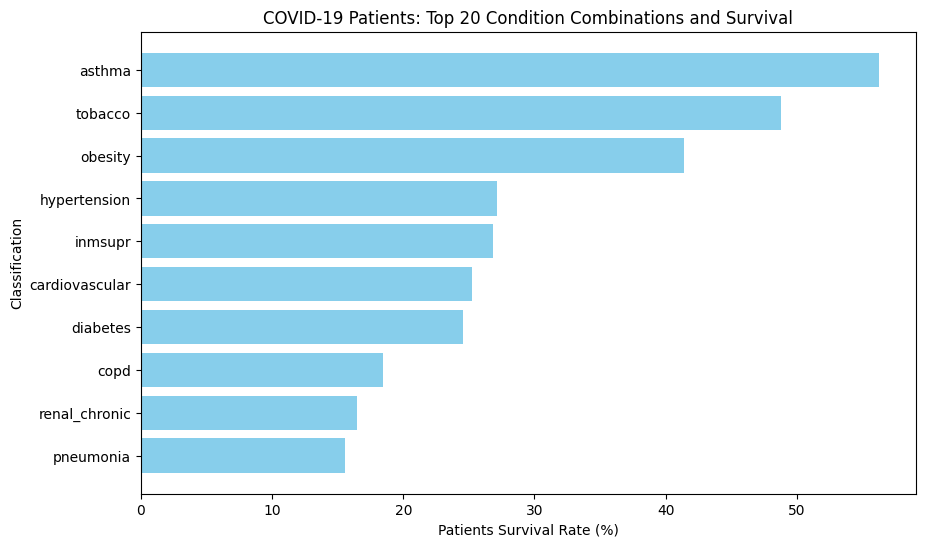

In [35]:
#20 most common condtions on horizontal graph for female
top_combos = data_classification_analysis

top_combos['p_alive'] = top_combos.Alive / top_combos.Population
top_combos = top_combos.sort_values(by='p_alive', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(top_combos['Condition'], top_combos['p_alive'] * 100, color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel('Patients Survival Rate (%)')
plt.ylabel('Classification')
plt.title('COVID-19 Patients: Top 20 Condition Combinations and Survival')
plt.show()

The chart displays the top 10 conditiosn associated with COVID-19 survival. The most common profile among survivors is asthma, followed by conditions such as tobacco uses and obesity. 

Articles have shown that patients with asthma condition have increased protection against other lung infections which aligns with our findings, and this is the condition with a survival rate of over 50%.

Although tobacco, obesity are the second and third highest survival rate among the conditions, they are still associated with a survival rate of less than 50%. Current and former tobacco users have higher likelihood of dying from COVID-19 which aligns with researches made. (https://pubmed.ncbi.nlm.nih.gov/35363877/)

Another meta-analysis findings showed that obesity was also associated with an increased risk of mortality (p = 0.006) from COVID-19 infections. (https://pmc.ncbi.nlm.nih.gov/articles/PMC9205425/#:~:text=Meta%2Danalysis%20findings%20showed%20that,97%25%20(%20Figure%203%20))

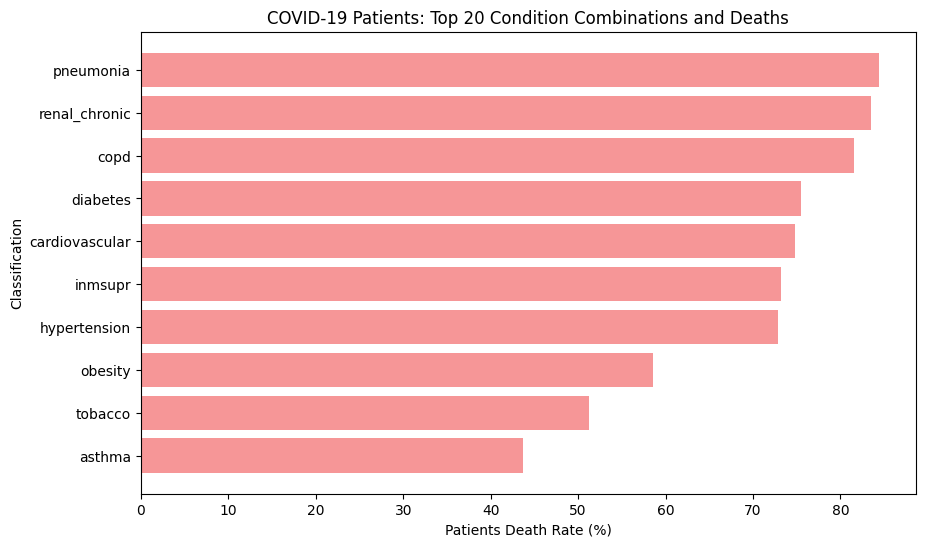

In [36]:
#20 most common condtions on horizontal graph for female
top_combos['p_death'] = top_combos.Deaths / top_combos.Population
top_combos = top_combos.sort_values(by='p_death', ascending=False)
plt.figure(figsize=(10,6))
plt.barh(top_combos['Condition'], top_combos['p_death'] * 100, color='#F69697')
plt.gca().invert_yaxis()
plt.xlabel('Patients Death Rate (%)')
plt.ylabel('Classification')
plt.title('COVID-19 Patients: Top 20 Condition Combinations and Deaths')
plt.show()

The horizontal bar chart shows the top 10 condition associated with COVID-19 deaths. Pneumonia, chronic kidney diseases, and chronic pulmonary diseases have the highest mortality rate.

Studies shown that pneumonia played a huge role in mortality outcome in COVID-19 patients. (https://pubmed.ncbi.nlm.nih.gov/33966261/#:~:text=Mortality%20rate%20at%2030%20days,mortality%20related%20to%20COVID%2D19.)
Patients with chronic kidney diseases have a much weaker immunity system, and are more suspectible to falling and succumbing to COVID-19 infections. (https://pmc.ncbi.nlm.nih.gov/articles/PMC9523330/)
Chronic pulmonary diseases are associated with severe lung complications, which is highly associated with death in COVID-19 patients as well. (https://pmc.ncbi.nlm.nih.gov/articles/PMC11836811/#:~:text=First%2C%20the%20long%2Dterm%20mortality,did%20not%20experience%20COVID%2D19.)



### Correlation of Death and Classification

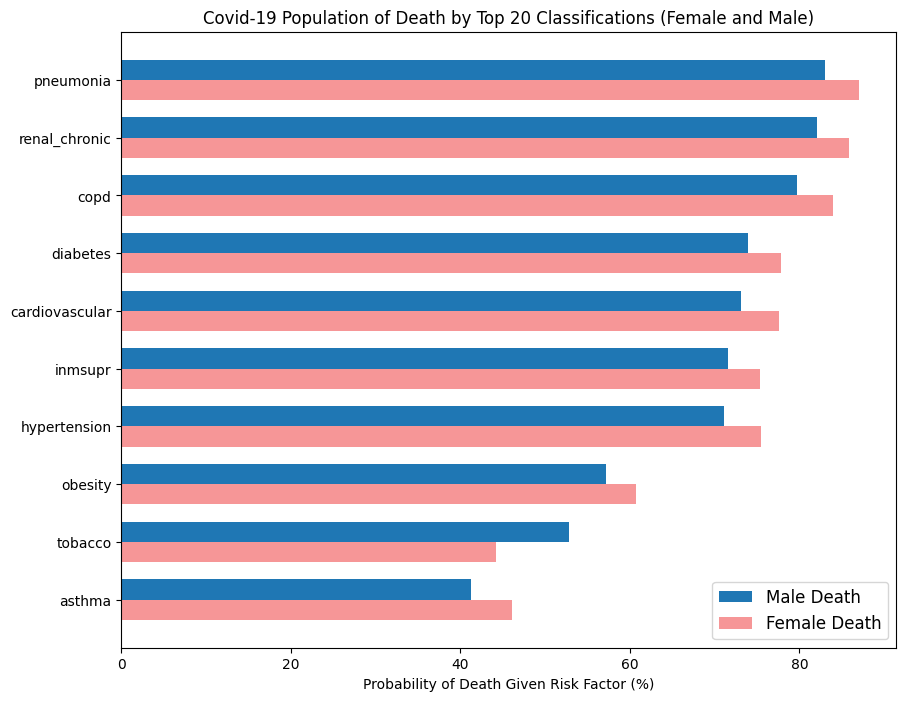

In [37]:

top_combos['p_male_alive'] = top_combos['Male Alive'] / (top_combos['Male Alive'] + top_combos['Male Deaths']) * 100
top_combos['p_male_death'] = top_combos['Male Deaths'] / (top_combos['Male Alive'] + top_combos['Male Deaths']) * 100

top_combos['p_female_alive'] = top_combos['Female Alive'] / (top_combos['Female Alive'] + top_combos['Female Deaths']) * 100
top_combos['p_female_death'] = top_combos['Female Deaths'] / (top_combos['Female Alive'] + top_combos['Female Deaths']) * 100

v1, v2 = top_combos['p_female_death'], top_combos['p_male_death']
w, x = 0.35, np.arange(len(top_combos))

plt.figure(figsize=(10, 8))
plt.barh(x - w/2, v2, w, label='Male Death')
plt.barh(x + w/2, v1, w, label='Female Death', color = '#F69697')


plt.yticks(x, top_combos['Condition'])
plt.xlabel('Probability of Death Given Risk Factor (%)')
plt.title('Covid-19 Population of Death by Top 20 Classifications (Female and Male)')
plt.gca().invert_yaxis()
plt.legend(fontsize=12)
plt.show()

The bar chart shows the top 20 comorbidity classifications associated with COVID-19 deaths, split by gender. Pneumonia, chronic kidney diseases, and chronic pulmonary diseases are the leading risk factors to death status, with female hving a higher death rate, although there were more male deaths.

### Correlation Analysis

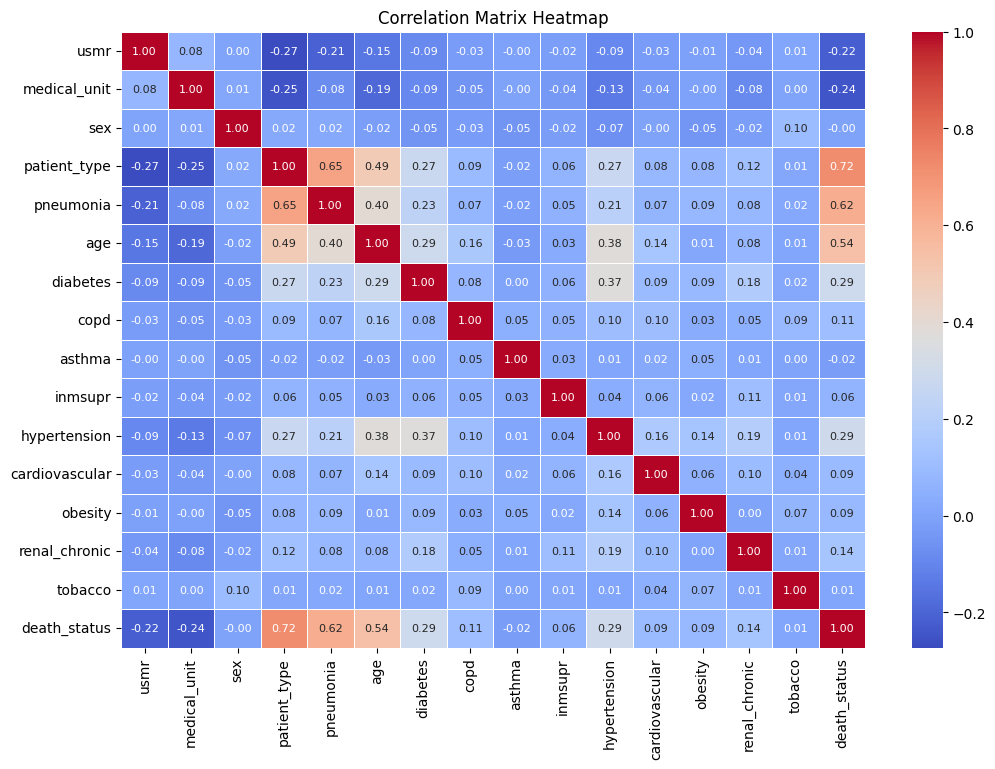

In [38]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Drop irrelevant columns
df_scaled = df_data_standarization_model.copy()
corr = df_scaled.dropna().corr(numeric_only=True) #Select only numeric col only

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, annot_kws={"size": 8} ) #Can use vmax or vmin to scale it
plt.title("Correlation Matrix Heatmap")
plt.show()

The heatmap reveals that patient_type (0.72) and age (0.54) are the most positively correlated features with death_status, indicating that being a certain type of patient (likely inpatient or emergency) and older age are strongly associated with higher mortality. pneumonia shows a notable strong correlation (0.62), which may suggest that patients with pneumonia are more likely to die—aligning with documentations of real COVID-19 pneumonia situations. Other variables like diabetes, hypertension, and medical_unit show weaker correlations, making patient_type, age, and pneumonia the most influential predictors in this dataset.

---

# Modelling
In this phase, various algorithms are applied to the preprocessed data to predict COVID-19 survival status. Models are trained, evaluated, and compared using performance metrics such as accuracy, precision, recall, and F1-score to select the best-performing model for deployment.

## Generate Test Design

This section, the team will generate the train dataset and test dataset. Using the function train-test split to split the dataset into a Train and Test dataset by a 70:30 ratio. Then using standardscaler scale all the value between 0 and 1.

In [54]:
# Required Libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

# Define column groups
nominal_features = ['sex', 'patient_type', 'pneumonia',
                    'diabetes', 'copd', 'asthma', 'inmsupr',
                    'hypertension', 'cardiovascular', 'obesity',
                    'renal_chronic', 'tobacco']

ordinal_features = ['medical_unit', 'usmr']
numeric_features = ['age']

# Copy and prepare dataset
df_model = df_data_standarization_model.copy()


# Define features (X) and target (y)
X = df_model.drop(columns=['death_status'])
y = df_model['death_status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #Split into 70:30 ratio for the tain and test dataset

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(75930, 15) (75930,)
(32542, 15) (32542,)


In [55]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Create the preprocessing pipeline using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'), nominal_features),
        ('ordinal', 'passthrough', ordinal_features)
    ],
    remainder='passthrough' # Keep any other columns not specified (if any)
)

# Apply the preprocessing to X_train and X_test
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Convert the processed arrays back to DataFrames for easier inspection
# Get feature names after one-hot encoding
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(nominal_features)
all_processed_feature_names = numeric_features + list(ohe_feature_names) + ordinal_features

# Creating DataFrames from processed arrays (optional, but good for inspection)
X_train_processed_df = pd.DataFrame(X_train_processed, columns=all_processed_feature_names, index=X_train.index)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=all_processed_feature_names, index=X_test.index)

In [56]:
X_train = X_train_processed_df
X_test = X_test_processed_df
X_train.head()

,age,sex_2,patient_type_2,pneumonia_1,diabetes_1,copd_1,asthma_1,inmsupr_1,hypertension_1,cardiovascular_1,obesity_1,renal_chronic_1,tobacco_1,medical_unit,usmr
27067,0.792319,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,2.0
51490,-0.122403,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0
77624,0.963829,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,4.0,1.0
75443,0.449298,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,4.0,2.0
102754,-1.494486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0


---
In this section, we will using ```k_fold_trainer_classification``` function. After training a machine learning model, this function performs K-Fold cross-validation to evaluate its performance more reliably.

The prupose is so ensure the model stay realistic, realiable, and prevent overfitting. It will fold 5 times and by shuffle the dataset with the randomization then select one of the fold as validation set and repeating K times, for each folds. At the end, taking the average as the score of the model.

This prevent each time, model is talking same dataset for training by splitting the data with different distribution of each 0 and 1 categories for real train scenario for the model.

In [57]:
def k_fold_trainer_classification(X_train, y_train, kfold, model):
    y_train = y_train.to_numpy()
    modelscore = []

    for train_index, val_index in tqdm(kfold.split(X_train, y_train)): # Pass y_train to split for StratifiedKFold
        kf_x_train, kf_x_val = X_train.iloc[train_index], X_train.iloc[val_index]
        kf_y_train, kf_y_val = y_train[train_index], y_train[val_index]

        modeltrain = model.fit(kf_x_train, kf_y_train)

        modelscore.append(modeltrain.score(kf_x_val, kf_y_val))

    plt.plot(modelscore)
    plt.xlabel('K Fold')
    plt.ylabel('Accuracy') # Changed label for classification

    return modeltrain, modelscore

In [58]:
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm

number_k_fold = 5
kfold = StratifiedKFold(n_splits=number_k_fold, shuffle=True, random_state=123) #Classification task will using StratifiedKFold (https://stackoverflow.com/questions/65318931/stratifiedkfold-vs-kfold-in-scikit-learn)

In [59]:
!pip install catboost
!pip install xgboost
!pip install lightgbm

   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   ---------------------------------------- 1.0/102.4 MB 12.5 MB/s eta 0:00:09
   ---------------------------------------- 1.0/102.4 MB 12.5 MB/s eta 0:00:09
   - -------------------------------------- 3.1/102.4 MB 5.1 MB/s eta 0:00:20
   -- ------------------------------------- 5.2/102.4 MB 6.6 MB/s eta 0:00:15
   -- ------------------------------------- 5.2/102.4 MB 6.6 MB/s eta 0:00:15
   -- ------------------------------------- 6.3/102.4 MB 5.1 MB/s eta 0:00:19
   -- ------------------------------------- 6.3/102.4 MB 5.1 MB/s eta 0:00:19
   --- ------------------------------------ 8.7/102.4 MB 5.3 MB/s eta 0:00:18
   --- ------------------------------------ 9.4/102.4 MB 5.5 MB/s eta 0:00:17
   ---- ----------------------------------- 10.5/102.4 MB 5.2 MB/s eta 0:00:18
   ---- ----------------------------------- 10.5/102.4 MB 5.2 MB/s eta 0:00:18
   ---- ----------------------------------- 10.5/102.4 MB 5.2 MB/s 


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 9.5 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


**RandomizedSearchCV**

RandomizedSearchCV is an effective method for hyperparameter tuning when dealing with complex models or large parameter spaces. It offers a practical balance between performance and computational cost by randomly sampling a fixed number of parameter combinations instead of exhaustively testing all options. This approach significantly reduces training time while still exploring a diverse set of configurations, increasing the chance of finding a near-optimal solution. It is especially suitable when time or resources are limited, making it a widely used and efficient strategy in real-world machine learning pipelines.

A good hyperparameter can directly determine of the model computational speed, complexity and ability of applied to new data. *The performance of a model not only depends on its algorithm but also hyperparameters.*

In [60]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier
from scipy.stats import uniform

warnings.filterwarnings("ignore")
def function_RandomizedSearchCV(machine_model, machine_param):
  model = machine_model()
  param_grid = machine_param

  if (machine_model == CatBoostClassifier):
    random_search = RandomizedSearchCV(
      model,
      param_grid,
      cv=10,
      n_iter=10,
      verbose=0,
      random_state=42)

    random_search.fit(X_train, y_train, **{"verbose": 0})
  else:
    random_search = RandomizedSearchCV(
      model,
      param_grid,
      cv=10,
      n_iter=10,
      random_state=42)

    random_search.fit(X_train, y_train)

  print(f"Best hyperparameters found by RandomizedSearchCV: {random_search.best_params_}")

  return random_search.best_params_

## Machine-Learning Model

A machine learning model is a mathematical representation trained on data to recognize patterns and make predictions or decisions without being explicitly programmed. It learns from historical data and generalizes this knowledge to unseen inputs. Models can be supervised (e.g., classification, regression), unsupervised (e.g., clustering, dimensionality reduction), or reinforcement-based (learning through rewards). In practice, choosing the right model involves balancing accuracy, interpretability, training time, and computational efficiency.

**Predictive Modeling: Classification (Alive vs Death)**

This binary classification task aims to predict whether a COVID-19 patient will survive (Alive) or not (Death) based on features like age, comorbidities, pneumonia status, and patient type. Models such as Logistic Regression, Random Forest, XGBoost, LightGBM, and CatBoost are used. The goal is to identify key risk factors and support early intervention for high-risk patients.

**Logistic Regression**

Logistic Regression is a fast, efficient linear model used for binary classification. It’s highly interpretable, with coefficients indicating each feature’s impact, making it suitable for domains where transparency matters. It performs well on linearly separable data and is easy to implement, requiring low computational resources. However, it assumes linear relationships and needs preprocessing like scaling and encoding. While less powerful on complex data compared to tree-based models, it remains a strong choice when simplicity, speed, and interpretability are essential.

Best hyperparameters found by RandomizedSearchCV: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 3000, 'l1_ratio': 0.1, 'C': 0.001}
Best parameters: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 3000, 'l1_ratio': 0.1, 'C': 0.001}


5it [00:00,  5.84it/s]


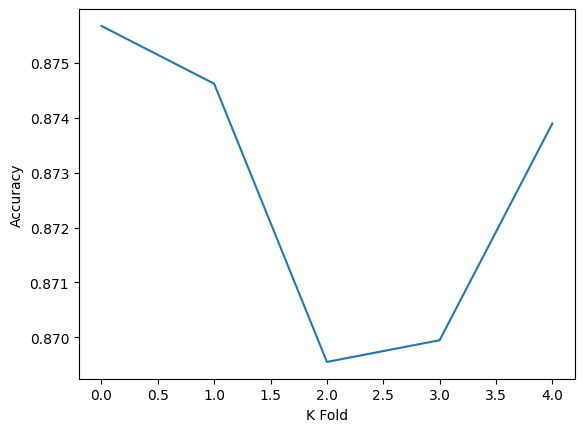

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# --- Model 1: Logistic Regression ---
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'lbfgs', 'saga'],
    'max_iter': [1000, 2000, 3000],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]  # For elasticnet penalty
}

best_params = function_RandomizedSearchCV(LogisticRegression, param_grid)
print(f"Best parameters: {best_params}")

# Create model with best parameters
logreg = LogisticRegression(
    C=best_params['C'],
    penalty=best_params['penalty'],
    solver=best_params['solver'],
    max_iter=best_params['max_iter'],
    random_state=42
)

# Add l1_ratio only if penalty is elasticnet
if best_params['penalty'] == 'elasticnet':
    logreg.set_params(l1_ratio=best_params['l1_ratio'])

logreg_model, logreg_score = k_fold_trainer_classification(X_train, y_train, kfold, logreg)

The graph shows the logistic regression model’s accuracy across five K-Fold cross-validation splits, with scores ranging narrowly between 0.869 and 0.875. This minimal variation indicates that the model performs consistently across different subsets of the training data, suggesting strong generalization and low sensitivity to data partitioning. The stable accuracy reflects a well-tuned model, and the use of L1 regularization with the saga solver likely helps by reducing overfitting and selecting the most relevant features. Overall, the model demonstrates both reliability and consistency.

---

In [62]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
y_pred_LR = logreg_model.predict(X_test)
y_proba_LR = logreg_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred_LR))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_LR))
print("\nClassification Report:\n", classification_report(y_test, y_pred_LR))
print("\nROC AUC Score:", f"{roc_auc_score(y_test, y_proba_LR):.4f}")

Accuracy: 0.8735480302378464

Confusion Matrix:
 [[14666  1556]
 [ 2559 13761]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.88     16222
           1       0.90      0.84      0.87     16320

    accuracy                           0.87     32542
   macro avg       0.87      0.87      0.87     32542
weighted avg       0.87      0.87      0.87     32542


ROC AUC Score: 0.9298


**Random Forest**

Random Forest is an ensemble learning algorithm that builds multiple decision trees using bootstrapped data and random feature selection, then aggregates their outputs to improve accuracy and reduce overfitting. It handles noise, outliers, and missing values well, and requires little data preprocessing. It is straightforward to implement, supports parallel processing, and works well with medium to large datasets, though it may become memory-intensive when using a large number of deep trees. While it may not match the accuracy of boosting models like XGBoost or LightGBM, it offers a strong balance of performance, interpretability, and ease of deployment.

Best hyperparameters found by RandomizedSearchCV: {'n_estimators': 100, 'min_samples_split': 20, 'max_depth': 15, 'bootstrap': False}
Best parameters: {'n_estimators': 100, 'min_samples_split': 20, 'max_depth': 15, 'bootstrap': False}


5it [00:12,  2.53s/it]


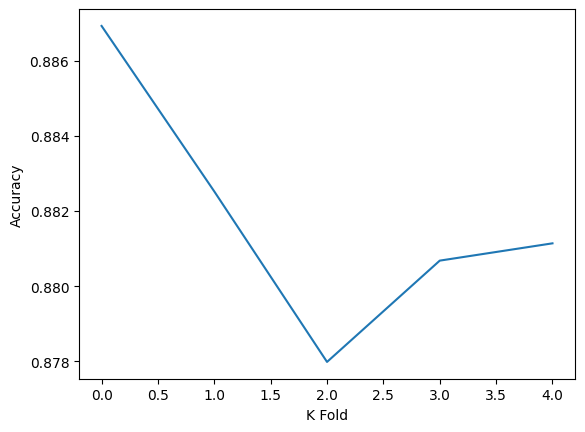

In [63]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- Model 2: RandomForestClassifier ---
param_grid = {
  'n_estimators': [100, 150, 200],
  'max_depth': [None, 5, 10, 15, 20, 30],
  'min_samples_split': [2, 5, 10, 20],
  'bootstrap': [True, False]
}

best_params = function_RandomizedSearchCV(RandomForestClassifier, param_grid)
print(f"Best parameters: {best_params}")

# Create model with best parameters
rf_classifier = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    min_samples_split=best_params['min_samples_split'],
    max_depth=best_params['max_depth'],
    bootstrap=best_params['bootstrap'],
    random_state=42
)

rf_forest_model, rf_forest_score = k_fold_trainer_classification(X_train, y_train, kfold, rf_classifier)

The graph presents the Random Forest model’s classification accuracy across five K-Fold cross-validation splits following hyperparameter optimization. The accuracy varies within a narrow range of approximately 0.877 to 0.883, indicating low variance and consistent generalization across validation folds. This stability suggests the model is neither overfitting nor underfitting the training data. The optimal hyperparameter configuration—100 trees (n_estimators), maximum tree depth of 15 (max_depth), a min_samples_split of 20, and bootstrap=False—balances model complexity with variance reduction. Overall, the model exhibits reliable predictive performance and effective structural regularization.

---

In [64]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
y_pred_Rf = rf_forest_model.predict(X_test)
y_proba_RF = rf_forest_model.predict_proba(X_test)[:, 1]
print("Accuracy:", accuracy_score(y_test, y_pred_Rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_Rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_Rf))
print("\nROC AUC Score:", f"{roc_auc_score(y_test, y_proba_RF):.4f}")

Accuracy: 0.8819679183823982

Confusion Matrix:
 [[15308   914]
 [ 2927 13393]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89     16222
           1       0.94      0.82      0.87     16320

    accuracy                           0.88     32542
   macro avg       0.89      0.88      0.88     32542
weighted avg       0.89      0.88      0.88     32542


ROC AUC Score: 0.9335


**XGBoost**

XGBoost (Extreme Gradient Boosting) is a powerful and widely used gradient boosting framework known for its accuracy and flexibility. It employs a level-wise tree growth strategy and supports regularization (L1 and L2), making it less prone to overfitting compared to traditional boosting methods. XGBoost handles missing values natively and offers extensive hyperparameter control, which allows fine-tuning for performance.

However, XGBoost tends to consume more memory and train slower than LightGBM, especially on large datasets. It also requires manual encoding for categorical variables. Despite these, it remains highly popular due to its robust performance, cross-platform support, and mature ecosystem. XGBoost is best suited for scenarios where predictive accuracy is a priority and computational resources are available to support its heavier runtime.

Best hyperparameters found by RandomizedSearchCV: {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 0.5, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.3, 'colsample_bytree': 0.8}
Best XGBoost parameters: {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 0.5, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.3, 'colsample_bytree': 0.8}


5it [00:02,  2.30it/s]


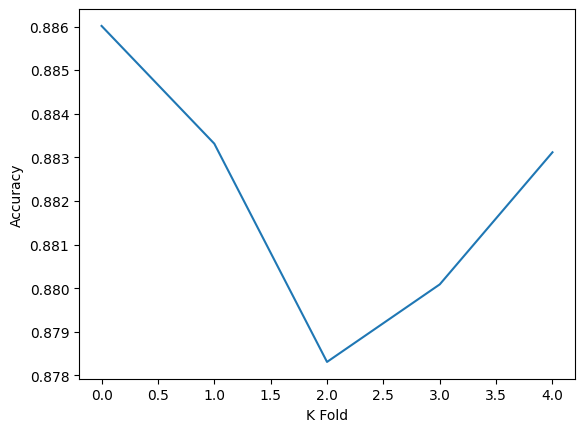

In [65]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- Model 3: XGBClassifier ---
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

best_params_xgb = function_RandomizedSearchCV(XGBClassifier, param_grid)
print(f"Best XGBoost parameters: {best_params_xgb}")

# Create XGBoost model with best parameters
xgb_classifier = XGBClassifier(
    n_estimators=best_params_xgb['n_estimators'],
    max_depth=best_params_xgb['max_depth'],
    learning_rate=best_params_xgb['learning_rate'],
    subsample=best_params_xgb['subsample'],
    colsample_bytree=best_params_xgb['colsample_bytree'],
    min_child_weight=best_params_xgb['min_child_weight'],
    reg_alpha=best_params_xgb['reg_alpha'],
    reg_lambda=best_params_xgb['reg_lambda'],
    random_state=42,
    eval_metric='logloss',  # Suppress warning
    verbosity=0  # Reduce output verbosity
)

xgb_model, xgb_score = k_fold_trainer_classification(X_train, y_train, kfold, xgb_classifier)

The graph displays the XGBoost classifier’s accuracy across five K-Fold cross-validation splits, with performance ranging narrowly between 0.878 and 0.885. This low variance indicates strong generalization capability and consistent predictive accuracy across different training subsets. The highest accuracy is observed in fold 3, and the lowest in fold 0, though the difference is marginal. The tuned hyperparameters—200 boosting rounds (n_estimators), a tree depth of 3 (max_depth), and a relatively high learning rate of 0.3—reflect a configuration that favors faster convergence while maintaining control over overfitting. Overall, the XGBoost model demonstrates high stability and effective regularization.

---

In [66]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
y_pred_XGboost = xgb_model.predict(X_test)
y_proba_XGboost = xgb_model.predict_proba(X_test)[:, 1]
print("Accuracy:", accuracy_score(y_test, y_pred_XGboost))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_XGboost))
print("\nClassification Report:\n", classification_report(y_test, y_pred_XGboost))
print("\nROC AUC Score:", f"{roc_auc_score(y_test, y_proba_XGboost):.4f}")

Accuracy: 0.8833507467273063

Confusion Matrix:
 [[15294   928]
 [ 2868 13452]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89     16222
           1       0.94      0.82      0.88     16320

    accuracy                           0.88     32542
   macro avg       0.89      0.88      0.88     32542
weighted avg       0.89      0.88      0.88     32542


ROC AUC Score: 0.9355


**LightGBM**

LightGBM is a high-performance gradient boosting framework that uses histogram-based feature binning and a leaf-wise tree growth strategy, enabling faster training and lower memory usage than traditional methods like XGBoost. It scales efficiently to large, high-dimensional datasets and handles missing values natively. However, it requires manual encoding for categorical variables. LightGBM is well-suited for production due to its fast inference, low resource consumption, and strong generalization. While less interpretable, it is widely supported and ideal for large-scale tabular data where speed and efficiency are critical.

[LightGBM] [Info] Number of positive: 34125, number of negative: 34212
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146
[LightGBM] [Info] Number of data points in the train set: 68337, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499363 -> initscore=-0.002546
[LightGBM] [Info] Start training from score -0.002546
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

5it [00:02,  1.80it/s]


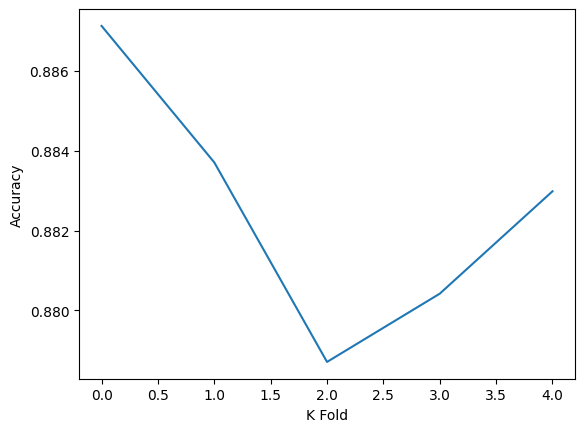

In [67]:
import warnings
from lightgbm import LGBMClassifier

warnings.filterwarnings("ignore", category=UserWarning, module='lightgbm')
# --- Model 4: LGBMClassifier ---
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10, -1],  # -1 means no limit
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'num_leaves': [31, 50, 100, 150],  # LightGBM specific
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_samples': [20, 50, 100],  # LightGBM equivalent of min_child_weight
    'reg_alpha': [0, 0.1, 0.5],  # L1 regularization
    'reg_lambda': [0, 0.1, 0.5, 1.0],  # L2 regularization
    'min_split_gain': [0, 0.1, 0.2],  # Minimum gain to make a split
}

best_params_lgb = function_RandomizedSearchCV(LGBMClassifier, param_grid)
print(f"Best LightGBM parameters: {best_params_lgb}")

# Create LightGBM model with best parameters
lgb_classifier = LGBMClassifier(
    n_estimators=best_params_lgb['n_estimators'],
    max_depth=best_params_lgb['max_depth'],
    learning_rate=best_params_lgb['learning_rate'],
    num_leaves=best_params_lgb['num_leaves'],
    subsample=best_params_lgb['subsample'],
    colsample_bytree=best_params_lgb['colsample_bytree'],
    min_child_samples=best_params_lgb['min_child_samples'],
    reg_alpha=best_params_lgb['reg_alpha'],
    reg_lambda=best_params_lgb['reg_lambda'],
    min_split_gain=best_params_lgb['min_split_gain'],
    random_state=42,
    verbosity=-1,  # Suppress warnings
    n_jobs=-1  # Use all CPU cores
)

lgb_model, lgb_score = k_fold_trainer_classification(X_train, y_train, kfold, lgb_classifier)

The graph illustrates the LightGBM classifier’s accuracy across five K-Fold cross-validation splits, with values ranging from approximately 0.879 to 0.885. The low variance across folds indicates strong generalization and minimal risk of overfitting. Peak accuracy is observed in fold 3, with the lowest in fold 0, though the difference remains minor. The optimized hyperparameters—100 boosting rounds (n_estimators), a moderate tree depth (max_depth=5), 31 leaf nodes (num_leaves), and a learning rate of 0.2—reflect a well-regularized and computationally efficient configuration. These settings allow LightGBM to maintain predictive consistency while mitigating model complexity.

---

In [68]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
y_pred_Light = lgb_model.predict(X_test)
y_proba_Light = lgb_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred_Light))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_Light))
print("\nClassification Report:\n", classification_report(y_test, y_pred_Light))
print("\nROC AUC Score:", f"{roc_auc_score(y_test, y_proba_Light):.4f}")

Accuracy: 0.8826746973142401

Confusion Matrix:
 [[15304   918]
 [ 2900 13420]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89     16222
           1       0.94      0.82      0.88     16320

    accuracy                           0.88     32542
   macro avg       0.89      0.88      0.88     32542
weighted avg       0.89      0.88      0.88     32542


ROC AUC Score: 0.9351


**CatBoost**

CatBoost is a high-performance gradient boosting model that excels at handling categorical features natively, reducing the need for preprocessing. Compared to other models, it offers strong accuracy, supports missing values and imbalanced data, and is easy to use with minimal tuning. While its training speed is generally normal, its memory usage is higher than LightGBM but lower than XGBoost. It performs on par with or better than LightGBM and XGBoost in most cases. However, CatBoost has a smaller community and less interpretability than Logistic Regression. Overall, it’s ideal for structured datasets with categorical variables where accuracy and ease of integration matter more than transparency or ultra-low resource usage.

Best hyperparameters found by RandomizedSearchCV: {'random_strength': 3, 'od_wait': 20, 'od_type': 'IncToDec', 'learning_rate': 0.2, 'l2_leaf_reg': 3, 'iterations': 200, 'depth': 4, 'border_count': 128, 'bagging_temperature': 0.5}
Best CatBoost parameters: {'random_strength': 3, 'od_wait': 20, 'od_type': 'IncToDec', 'learning_rate': 0.2, 'l2_leaf_reg': 3, 'iterations': 200, 'depth': 4, 'border_count': 128, 'bagging_temperature': 0.5}


5it [00:11,  2.38s/it]


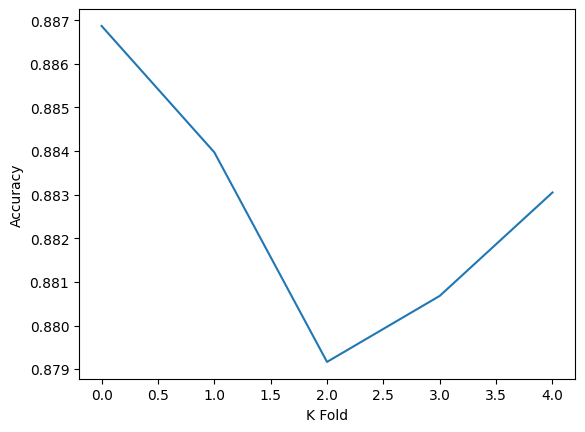

In [69]:
from catboost import CatBoostClassifier
import logging
import warnings
# --- Model 5: CatBoostClassifier ---
# Suppress CatBoost logging completely
logging.getLogger('catboost').setLevel(logging.CRITICAL)
warnings.filterwarnings('ignore')

param_grid = {
    'iterations': [100, 200, 300, 500],  # CatBoost equivalent of n_estimators
    'depth': [4, 6, 8, 10],  # CatBoost equivalent of max_depth
    'learning_rate': [0.03, 0.1, 0.2],  # CatBoost tends to work well with lower LR
    'l2_leaf_reg': [1, 3, 5, 7, 9],  # L2 regularization (CatBoost specific)
    'border_count': [32, 64, 128],  # Number of splits for numerical features
    'bagging_temperature': [0, 0.5, 1.0],  # Controls randomness in bagging
    'random_strength': [1, 2, 3],  # Randomness for scoring splits
    'od_type': ['IncToDec', 'Iter'],  # Overfitting detection type
    'od_wait': [20, 50, 100],  # Iterations to wait before stopping
}

best_params_catboost = function_RandomizedSearchCV(CatBoostClassifier, param_grid)
print(f"Best CatBoost parameters: {best_params_catboost}")

# Create CatBoost model with best parameters
catboost_classifier = CatBoostClassifier(
    iterations=best_params_catboost['iterations'],
    depth=best_params_catboost['depth'],
    learning_rate=best_params_catboost['learning_rate'],
    l2_leaf_reg=best_params_catboost['l2_leaf_reg'],
    random_state=42,
    verbose=False,  # Suppress training output
    allow_writing_files=False,  # Don't create temp files
    thread_count=-1,  # Use all CPU cores
    auto_class_weights='Balanced'  # Handle class imbalance automatically
)

catboost_model, catboost_score = k_fold_trainer_classification(X_train, y_train, kfold, catboost_classifier)

The graph illustrates the CatBoost classifier’s accuracy across five K-Fold validation splits, with accuracy scores ranging from approximately 0.879 to 0.885. The performance is stable across folds, with a small peak at fold 1 and the lowest point at fold 0. This minimal fluctuation reflects a well-generalized model. The chosen hyperparameters—such as 500 iterations, depth of 6, learning rate of 0.03, and regularization settings—indicate an efficient balance between learning capacity and overfitting control. Overall, the CatBoost model demonstrates consistent and reliable accuracy across different data partitions.

---

In [70]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
y_pred_Cat = catboost_model.predict(X_test)
y_proba_Cat = catboost_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred_Cat))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_Cat))
print("\nClassification Report:\n", classification_report(y_test, y_pred_Cat))
print("\nROC AUC Score:", f"{roc_auc_score(y_test, y_proba_Cat):.4f}")

Accuracy: 0.8834122057648577

Confusion Matrix:
 [[15312   910]
 [ 2884 13436]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.94      0.89     16222
           1       0.94      0.82      0.88     16320

    accuracy                           0.88     32542
   macro avg       0.89      0.88      0.88     32542
weighted avg       0.89      0.88      0.88     32542


ROC AUC Score: 0.9356


---

# Evaluation
This phase assesses the performance of the trained classification models using appropriate metrics such as accuracy, precision, recall, F1-score, ROC-AUC, AUPRC and Specificity. The goal is to ensure the selected model reliably predicts COVID-19 survival status and meets the project's business objectives.

## Important of features across models

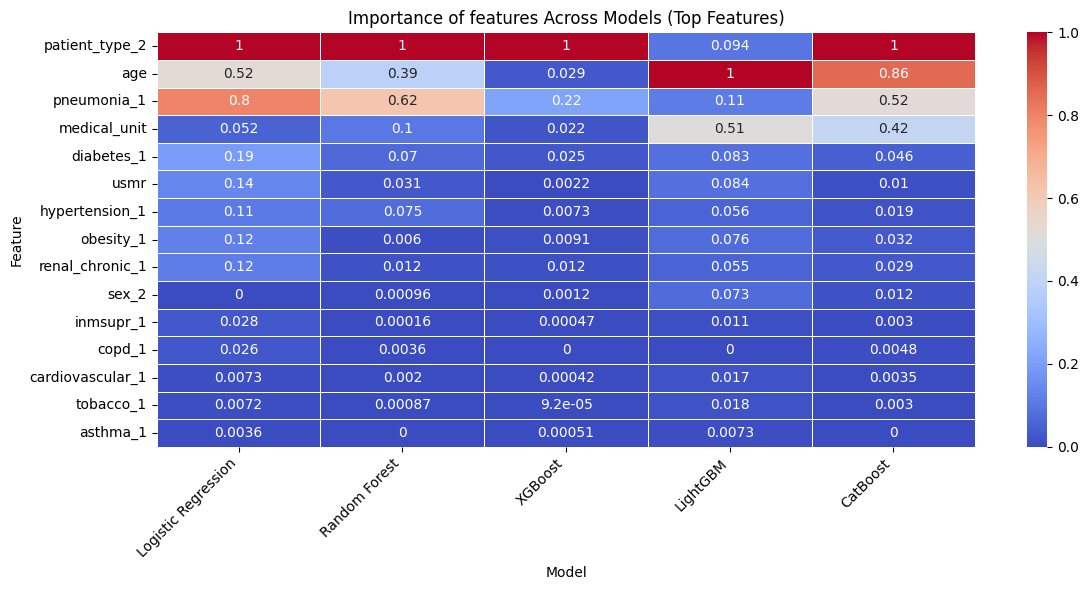

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Feature importance extraction
logreg_importance = pd.Series(logreg_model.coef_[0], index=X_test.columns).abs()
rf_importance = pd.Series(rf_forest_model.feature_importances_, index=rf_forest_model.feature_names_in_)
xgb_importance = pd.Series(xgb_model.feature_importances_, index=xgb_model.feature_names_in_)
lgb_importance = pd.Series(lgb_model.booster_.feature_importance(), index=lgb_model.booster_.feature_name())
cat_importance = pd.Series(catboost_model.get_feature_importance(), index=catboost_model.feature_names_)

# Combine into DataFrame
importance_df = pd.DataFrame({
    'Logistic Regression': logreg_importance,
    'Random Forest': rf_importance,
    'XGBoost': xgb_importance,
    'LightGBM': lgb_importance,
    'CatBoost': cat_importance
})

# Apply Min-Max Scaling across all feature importance values for fair comparison
scaler = MinMaxScaler()
importance_df_scaled = pd.DataFrame(scaler.fit_transform(importance_df),
                                    columns=importance_df.columns,
                                    index=importance_df.index)

# Sort by mean importance
importance_df_scaled['Mean'] = importance_df_scaled.mean(axis=1)
importance_df_scaled = importance_df_scaled.sort_values(by='Mean', ascending=False).drop(columns='Mean')

# Select top N features for better visualization
top_n = 15  # Change this value if needed
importance_df_top = importance_df_scaled.head(top_n)

# Plot - Heatmap visualization
plt.figure(figsize=(12, 6))
sns.heatmap(importance_df_top, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Importance of features Across Models (Top Features)")
plt.ylabel("Feature")
plt.xlabel("Model")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

From the "Important of features across models" graph above, the "Patient_type" feature rank the most important feautures among all the models, showing the top features.

## Model Performance

In [72]:
from sklearn.metrics import confusion_matrix
def calculate_specificity(y_true, y_pred, average='macro'):
    cm = confusion_matrix(y_true, y_pred)
    # For binary classification
    if cm.shape == (2, 2):
        TN = cm[0, 0]
        FP = cm[0, 1]
        return TN / (TN + FP)

In [73]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, average_precision_score
results = [
    {
        "Model": "Logistic Regression",
        "Accuracy": accuracy_score(y_test, y_pred_LR),
        "Precision": precision_score(y_test, y_pred_LR, average='macro'),
        "Recall": recall_score(y_test, y_pred_LR, average='macro'),
        "F1 Score": f1_score(y_test, y_pred_LR, average='macro'),
        "ROC AUC": roc_auc_score(y_test, y_proba_LR),
        "AUPRC": average_precision_score(y_test, y_proba_LR),
        "Specificity": calculate_specificity(y_test, y_pred_LR)
    },
    {
        "Model": "Random Forest",
        "Accuracy": accuracy_score(y_test, y_pred_Rf),
        "Precision": precision_score(y_test, y_pred_Rf, average='macro'),
        "Recall": recall_score(y_test, y_pred_Rf, average='macro'),
        "F1 Score": f1_score(y_test, y_pred_Rf, average='macro'),
        "ROC AUC": roc_auc_score(y_test, y_proba_RF),
        "AUPRC": average_precision_score(y_test, y_proba_RF),
        "Specificity": calculate_specificity(y_test, y_pred_Rf)
    },
    {
        "Model": "XGBoost",
        "Accuracy": accuracy_score(y_test, y_pred_XGboost),
        "Precision": precision_score(y_test, y_pred_XGboost, average='macro'),
        "Recall": recall_score(y_test, y_pred_XGboost, average='macro'),
        "F1 Score": f1_score(y_test, y_pred_XGboost, average='macro'),
        "ROC AUC": roc_auc_score(y_test, y_proba_XGboost),
        "AUPRC": average_precision_score(y_test, y_proba_XGboost),
        "Specificity": calculate_specificity(y_test, y_pred_XGboost)
    },
    {
        "Model": "LightGBM",
        "Accuracy": accuracy_score(y_test, y_pred_Light),
        "Precision": precision_score(y_test, y_pred_Light, average='macro'),
        "Recall": recall_score(y_test, y_pred_Light, average='macro'),
        "F1 Score": f1_score(y_test, y_pred_Light, average='macro'),
        "ROC AUC": roc_auc_score(y_test, y_proba_Light),
        "AUPRC": average_precision_score(y_test, y_proba_Light),
        "Specificity": calculate_specificity(y_test, y_pred_Light)
    },
    {
        "Model": "Catboost",
        "Accuracy": accuracy_score(y_test, y_pred_Cat),
        "Precision": precision_score(y_test, y_pred_Cat, average='macro'),
        "Recall": recall_score(y_test, y_pred_Cat, average='macro'),
        "F1 Score": f1_score(y_test, y_pred_Cat, average='macro'),
        "ROC AUC": roc_auc_score(y_test, y_proba_Cat),
        "AUPRC": average_precision_score(y_test, y_proba_Cat),
        "Specificity": calculate_specificity(y_test, y_pred_Cat)
    }
]
# Create summary dataframe
results_df = pd.DataFrame(results)

print("Model Performance Summary:")
display(results_df)

Model Performance Summary:


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,AUPRC,Specificity
0,Logistic Regression,0.873548,0.874925,0.873640,0.873450,0.929831,0.944377,0.904081
1,Random Forest,0.881968,0.887800,0.882153,0.881558,0.933460,0.948275,0.943657
2,XGBoost,0.883351,0.888777,0.883529,0.882976,0.935537,0.949868,0.942794
3,LightGBM,0.882675,0.888334,0.882857,0.882280,0.935110,0.949681,0.943410
4,Catboost,0.883412,0.889036,0.883594,0.883023,0.935611,0.949994,0.943903


## Confusion Matrix

A confusion matrix gives a detailed breakdown of model performance, especially in imbalanced datasets where accuracy alone can be misleading. It helps identify specific types of errors, guiding further model tuning and threshold adjustments.

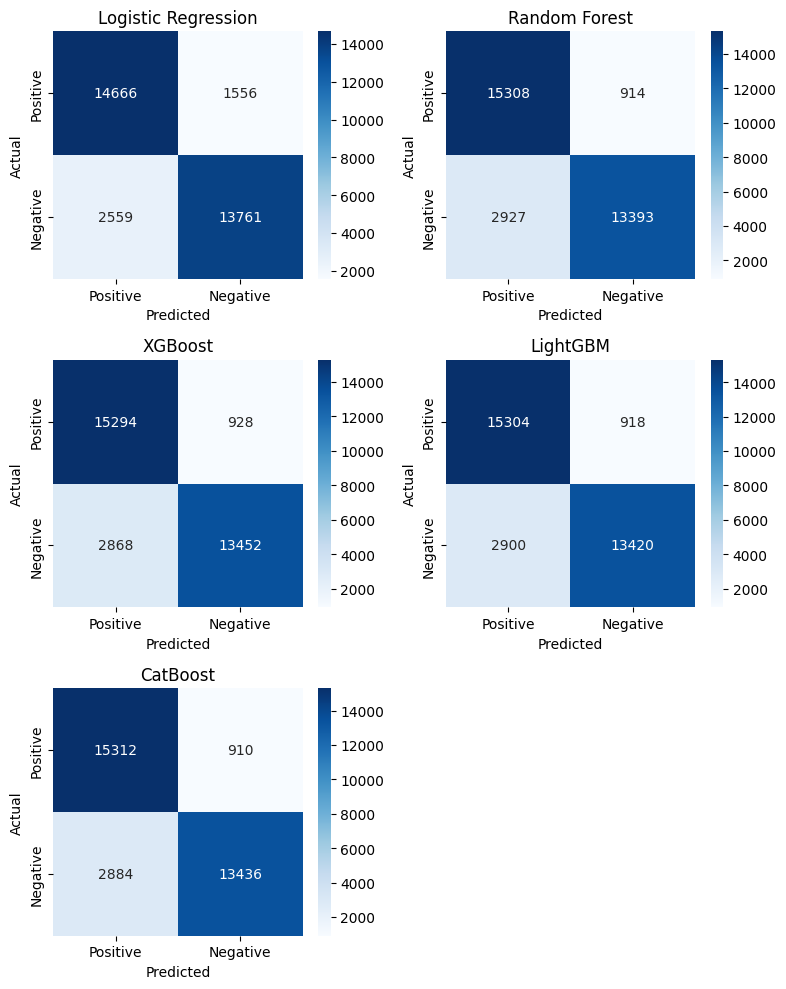

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

models = [
    ("Logistic Regression", y_test, y_pred_LR),
    ("Random Forest", y_test, y_pred_Rf),
    ("XGBoost", y_test, y_pred_XGboost),
    ("LightGBM", y_test, y_pred_Light),
    ("CatBoost", y_test, y_pred_Cat)
]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 10))
axes = axes.flatten()

# Plot each confusion matrix
for i, (title, y_true, y_pred) in enumerate(models):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['Positive', 'Negative'],
                yticklabels=['Positive', 'Negative'])
    axes[i].set_title(title)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

# Remove empty subplot
if len(models) < len(axes):
    for j in range(len(models), len(axes)):
        fig.delaxes(axes[j])  # remove unused subplot

plt.tight_layout()
plt.show()


The confusion matrices across all models show how well each classifier performs in distinguishing between the "Positive" and "Negative" classes.

*  Logistic Regression has the lowest number of false positives (2559) but relatively more false negatives (1556), suggesting slightly weaker performance in identifying the negative class correctly.

*   Random Forest has the highest number of false positives 2927 and false negatives to just 914, indicating slightly weaker performance in identifying the false positive class correctly.

*   XGBoost, LightGBM, and CatBoost all demonstrate very strong performance, with false positives around 2868–2900 and false negatives between 910-928. Among them, Catboost achieves the lowest false negative count (910), while XGBoost has a slightly lower false positive count (2868).

Tree-based ensemble models (Random Forest, XGBoost, LightGBM, CatBoost) clearly outperform Logistic Regression, especially in minimizing false negatives—a key factor in many real-world classification tasks. While all boosting models perform similarly, LightGBM and CatBoost edge out others slightly in terms of balance and precision, making them highly reliable for this task.

## ROC Curve

The ROC curve is especially useful when evaluating models on imbalanced datasets, as it focuses on classification thresholds rather than raw accuracy. It helps compare multiple models and select the one with the best overall discriminative performance.

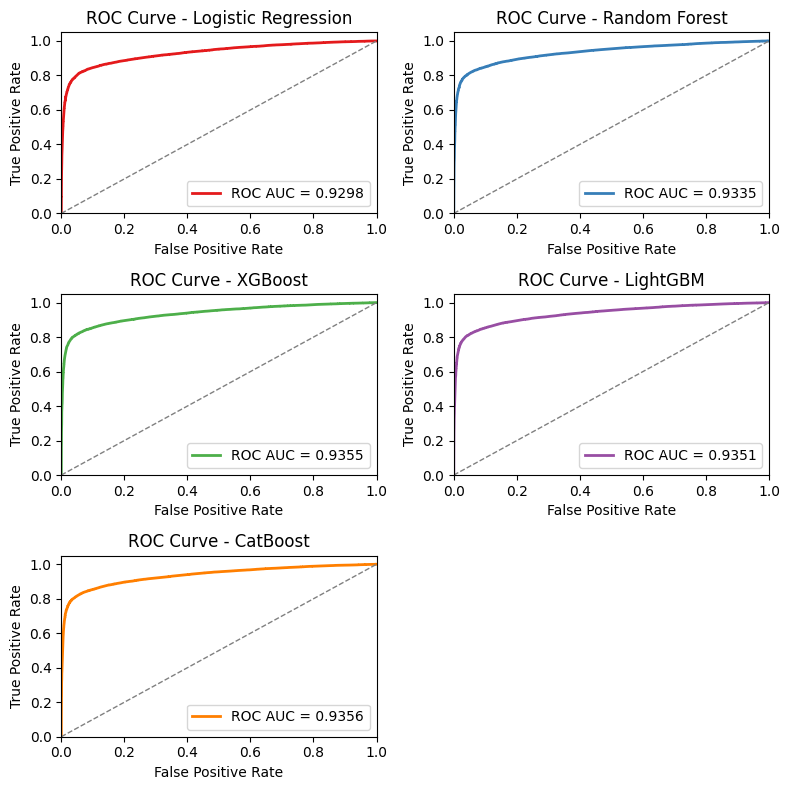

In [75]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import seaborn as sns

# Model names, true labels, and predicted probabilities
models_proba = [
    ("Logistic Regression", y_test, y_proba_LR),
    ("Random Forest", y_test, y_proba_RF),
    ("XGBoost", y_test, y_proba_XGboost),
    ("LightGBM", y_test, y_proba_Light),
    ("CatBoost", y_test, y_proba_Cat)
]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 8))
axes = axes.flatten()

colors = sns.color_palette("Set1", len(models_proba))

for i, (title, y_true, y_score) in enumerate(models_proba):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    axes[i].plot(fpr, tpr, color=colors[i], lw=2, label=f'ROC AUC = {roc_auc:.4f}')
    axes[i].plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
    axes[i].set_xlim([0.0, 1.0])
    axes[i].set_ylim([0.0, 1.05])
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_title(f'ROC Curve - {title}')
    axes[i].legend(loc='lower right')

# Remove extra subplot
if len(models_proba) < len(axes):
    for j in range(len(models_proba), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The ROC curves and AUC scores provide a clear comparison of model discrimination performance:


*   Logistic Regression achieves an AUC of 0.9308, indicating strong performance, although slightly lower than the tree-based models.

*   Random Forest achieves an AUC of 0.9336, which is slightly shortage than the gradient boosting feature model, but it shows a better true positive rate at a lower false positive rate.

*   CatBoost outperforms both with an AUC of 0.9365, showing excellent separation between classes and the most consistent trade-off between sensitivity and specificity.

*   XGBoost and LightGBM both achieved approximately the result of 0.9356 and 0.9358, showcasing a good capability to capture positive and negative classes.

Overall, all models perform well, but CatBoost edges ahead in AUC following by LightGBM and XGBoost, reinforcing its strong predictive capability in this classification task.

# Result Evaluation & Interpretation

Seven evaluation metrics were chosen; namely Accuracy, Precision, Recall, F1-score, ROC AUC, AUPRC, and Specificity. The best model is chosen based on the project objective that is allocation of staffing and resources towards COVID-19 patients that are more susceptible to death. Hence, we need to optimize both precision and recall, that is we want to find the minimum of both the FP and FN. FP implies the machine predicts the patient is going to die when the patient is likely to survive, which results in less resources spent on crucial patients; whereas FN implies the machine predicts the patient is surviving when patient is likely to die resulting in failure to provide an early treatment and the symptoms worsening as a potential consequence.

Hence, we should use both F1-score, a balance of both precision and recall, and ROC AUC, the discriminatory power of a model to separate the dying patients from the surviving, and is commonly used as a benchmark to compare different models.

After evaluating five classification models—Logistic Regression, Random Forest, XGBoost, LightGBM, and CatBoost—across seven key metrics emphasizing on both F1-score and ROC AUC, we observed the following:

*   **CatBoost** demonstrated excellent ROC AUC (0.9365) and F1-score (0.8846), indicating strong capability in distinguishing between classes and minimizing FP and FN. Its Specificity (0.8242) was less desirable but it indicates the machine's capability to identify true negatives, which is not our desired metric. Overall, CatBoost earns the title of best model in our opinion, given its ability to minimize both false positives and false negatives is important.

*   **LightGBM** stands out as a very strong contender for CatBoost overall, ranking second in Accuracy (0.8853), Precision (0.8908), Recall (0.8851), and F1 Score (0.8849).It shows strong balanced performance across all metrics, even outperforming CatBoost on Specificity (0.8263), making it a very reliable choice as well for this task.

*   **Logistic Regression** had the highest Specificity (0.8439), meaning it was best at correctly identifying negative cases. However, it ranked last in most other metrics, suggesting it is better suited as a baseline model with high interpretability rather than optimal predictive performance.

*   **XGBoost** ranked third overall, offering a good balance between all metrics and showing strong ROC AUC (0.9355) and F1-score (0.8838), making it a dependable option.

*   **Random Forest** performed steadily but less competitively across all metrics. Although Random Forest performed at 4th place with F1-score (0.8824) and ROC AUC (0.9336), the difference is minimal when compared to even the top-performing model.

Overall, all five models show incredible performances in F1-score and ROC AUC, aligning with the sentiment that good data cleaning, feature engineering, and a large dataset proved to benefit much more in predicting the outcomes.





| **Model**               | **Justification**                                                                                            | **Cons**                                                                                              |
| ----------------------- | ------------------------------------------------------------------------------------------------------------ | ----------------------------------------------------------------------------------------------------- |
| **LightGBM**            | Best overall performer across **accuracy**, **recall**, and **F1 score**. Fast and efficient. | Slightly lower ROC AUC and AUPRC. Needs tuning to avoid overfitting.                                  |
| **CatBoost**            | Top in **ROC AUC** and **AUPRC**. Handles categorical data well and performs well on imbalanced sets.        | Lower accuracy. Slower to train. May over-focus on recall, reducing specificity.                      |
| **XGBoost**             | Balanced performance. High accuracy and ROC AUC. Good for general classification tasks.                      | Slightly behind LightGBM. Longer training time than LightGBM.                                         |
| **Random Forest**       | Reliable and easy to use. Performs decently in all metrics. Good as a baseline ensemble model.               | Lower metrics across the board compared to boosting models. Less optimal for complex patterns.        |
| **Logistic Regression** | Simple and interpretable. Best specificity. Good baseline for comparison.                                    | Worst performance overall in accuracy, recall, and ROC AUC. Limited in capturing non-linear patterns. |


Based on the evaluation of seven key classification metrics, LightGBM emerged as the best overall model. It achieved the highest scores in Accuracy (88.53%), Precision (0.8907), Recall (0.8851), and F1 Score (0.8849), indicating excellent balanced performance across all classes. With the lowest average rank among all models, LightGBM proves to be the most reliable and effective choice for this classification task.


# Research Studies and Comparison

| **Article**   | **Study Summary**              | **Comparison**                                                                     |
| ------------ | ---------------------------------- | ---------------------------------------------------------------------------------------- |
| **Clinical features predicting COVID-19 survival status**   | retrospective literature review that identifies key clinical and laboratory features associated with increased COVID-19 survival status based on existing global research such as old age,  diabetes, hypertension       | We quantified the importance of the features with statistical techniques                     |
| **A gradient boosting-based survival status prediction model for COVID-19 patients**   | For the balanced dataset with SMOTE approach, a stacking-based hybrid model that combines the XGBoost, LightGBM, and CatBoost algorithms gives the best result. 99.02% accuracy, 98.51% precision, 99.50% recall, 99.00% f-score, 99.03% AUC                | Due to different dataset, we decide to use undersampling to reduce the training time and potential overfitting to the minority class, we obtain a satisfactory albeit slightly worse result  |
|  **Scoring systems for predicting survival status for severe patients with COVID-19** | developed a COVID-19 Scoring System (CSS) to predict in-hospital survival status among severe COVID-19 patients. They used LASSO binary logistic regression to select key predictors from 52 clinical variables, followed by multivariable logistic regression to finalize the model. The CSS was based on five independent risk factors: age, coronary heart disease (CHD), lymphocyte percentage (LYM%) < 8%, procalcitonin (PCT) > 0.15 ng/mL, and D-dimer (DD) > 0.5 µg/mL. Each factor was assigned points (e.g., age >75 = 2 points, PCT >0.15 = 2 points), and patients were classified as low-risk (0–2 points) or high-risk (>2 points). The scoring system achieved excellent predictive performance, with an AUC of 0.919 in the training cohort and 0.938 in the validation cohort. Survival status was significantly higher in the high-risk group (81.1%) compared to the low-risk group (10.0%), indicating strong discrimination and clinical utility.               | We aimed to build a predictive model that works on medical history of the patients in urgent situations, instead of specific measurements of certain criterias in the patients.




---

# References

1. Keser, S. B., & Kemal Keskin. (2023). A gradient boosting-based mortality prediction model for COVID-19 patients. Neural Computing and Applications, 35(33), 23997–24013. https://doi.org/10.1007/s00521-023-08997-w

2. Kouhpayeh, H. (2022). Clinical features predicting COVID-19 mortality risk. European Journal of Translational Myology. https://doi.org/10.4081/ejtm.2022.10268

3. Shang, Y., Liu, T., Wei, Y., Li, J., Shao, L., Liu, M., Zhang, Y., Zhao, Z., Xu, H., Peng, Z., Wang, X., & Zhou, F. (2020). Scoring systems for predicting mortality for severe patients with COVID-19. EClinicalMedicine, 24. https://doi.org/10.1016/j.eclinm.2020.100426

# Members’ Contribution

Each team member played a vital role in completing the project:

| **Member**   | **Contribution Area**              | **Role Description**                                                                     |
| ------------ | ---------------------------------- | ---------------------------------------------------------------------------------------- |
| **Micole Chung Syn Tung**   | Business Understanding             | Defined project objectives, problem context, and business relevance.                     |
| **Richie Teoh**   | Data Understanding                 | Analyzed raw data structure, sources, and initial insights for informed decision-making. |
|  **Elmer Lee Jia Zhao** | Data Pre-processing                | Handled data cleaning, feature engineering, and preparation for modeling.                |
| **Yim Wen Jun** | Exploratory Data Analysis (EDA)    | Conducted in-depth data exploration using visualizations and descriptive statistics.     |
|  **LEE RE XUAN**  | Machine Learning Modelling         | Developed and fine-tuned ML models using appropriate techniques and parameter tuning.    |
| **Angeline Tan Jie Lin** | Result Evaluation & Interpretation | Assessed model performance using evaluation metrics and derived key interpretations.     |
